In [2]:
# import useful packages
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Reset the default graph for rerun notebook
tf.reset_default_graph()

# Reset the random seed for reproducibility
np.random.seed(42)
tf.set_random_seed(42)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


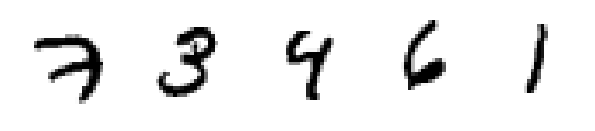

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [5]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")
# y_pred = tf.placeholder(shape=[None], dtype=tf.int64, name="y_pred")

In [6]:
# Conv layer
conv1_params = {
   "filters": 256,
   "kernel_size": 9,
   "strides": 1,
   "padding": "valid",
   "activation": tf.nn.relu,
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)

In [7]:
# Primary Capsnes
caps1_n_maps = 32
caps1_n_dims = 8

conv2_params = {
   "filters": caps1_n_maps * caps1_n_dims,
   "kernel_size": 9,
   "strides": 2,
   "padding": "valid",
   "activation": tf.nn.relu
}

conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

In [8]:
caps1_n_caps = caps1_n_maps * 6 * 6

caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name="caps1_raw")

In [9]:
# squash = ||s||^2 / (1 + ||s||^2) * s / ||s||

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        squash_factor = squared_norm / (1. + squared_norm)
        
        safe_norm = tf.sqrt(squared_norm + epsilon)

        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [10]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [11]:
# Digit Capsules

# Weights
caps2_n_caps = 10
caps2_n_dims = 16

init_sigma = 0.01

W_init = tf.random_normal(shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
                          stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [12]:

caps1_output_expanded = tf.expand_dims(caps1_output, -1, name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2, name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")

In [13]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name="caps2_predicted")

In [14]:
# iterations 3
b = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=np.float32, name="raw_weights")

c = tf.nn.softmax(b, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(c, caps2_predicted, name="weighted_predictions")
s = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum")
v = squash(s, axis=-2, name="caps2_output_round_1")

In [15]:
# iteration 2
v_tiled = tf.tile(v, [1, caps1_n_caps, 1, 1, 1], name="caps2_output_round_1_tiled")
agreement = tf.matmul(caps2_predicted, v_tiled, transpose_a=True, name="agreement")
b = tf.add(b, agreement, name="raw_weights_round_2")
c = tf.nn.softmax(b, dim=2, name="routing_weights_round_2")
weighted_predictions = tf.multiply(c, caps2_predicted, name="weighted_predictions_round_2")
s = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum_round_2")
v = squash(s, axis=-2, name="caps2_output_round_2")

In [16]:
# iteration 3
v_tiled = tf.tile(v, [1, caps1_n_caps, 1, 1, 1], name="caps2_output_round_2_tiled")
agreement = tf.matmul(caps2_predicted, v_tiled, transpose_a=True, name="agreement")
b = tf.add(b, agreement, name="raw_weights_round_3")
c = tf.nn.softmax(b, dim=2, name="routing_weights_round_3")
weighted_predictions = tf.multiply(c, caps2_predicted, name="weighted_predictions_round_3")
s = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum_round_3")
v = squash(s, axis=-2, name="caps2_output_round_3")

In [17]:
# margin loss
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

v_norm = tf.norm(v, axis=-2, keep_dims=True, name="caps2_output_norm")

FP_raw = tf.square(tf.maximum(0., m_plus - v_norm), name="FP_raw")
FP = tf.reshape(FP_raw, shape=(-1, 10), name="FP")

FN_raw = tf.square(tf.maximum(0., v_norm - m_minus), name="FN_raw")
FN = tf.reshape(FN_raw, shape=(-1, 10), name="FN")

L = tf.add(T * FP, lambda_ * (1.0 - T) * FN, name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")


In [18]:
# Mask
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                             name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                               lambda: y,        # if True
                               lambda: y_pred,   # if False
                               name="reconstruction_targets")
reconstruction_mask = tf.one_hot(reconstruction_targets, depth=caps2_n_caps, name="reconstruction_mask")
reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1], name="reconstruction_mask_reshaped")
caps2_output_masked = tf.multiply(v, reconstruction_mask_reshaped, name="caps2_output_masked")

In [19]:
# Decoder
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

decoder_input = tf.reshape(caps2_output_masked,
                         [-1, caps2_n_caps * caps2_n_dims],
                         name="decoder_input")

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                            activation=tf.nn.relu,
                            name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                            activation=tf.nn.relu,
                            name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                   activation=tf.nn.sigmoid,
                                   name="decoder_output")

In [20]:
# Refactor loss
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                              name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                   name="reconstruction_loss")

In [21]:
# Final loss
alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [22]:
# Other settings
# 全局初始化
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# 计算精度
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

# 用 Adam 优化器
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [ ]:
# Training 
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%) Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {} Val accuracy: {:.4f}% Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

In [ ]:
# Validation
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}% Loss: {:.6f}".format(
        acc_test * 100, loss_test))

In [ ]:
# Prediction
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

In [ ]:
# Draw
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()